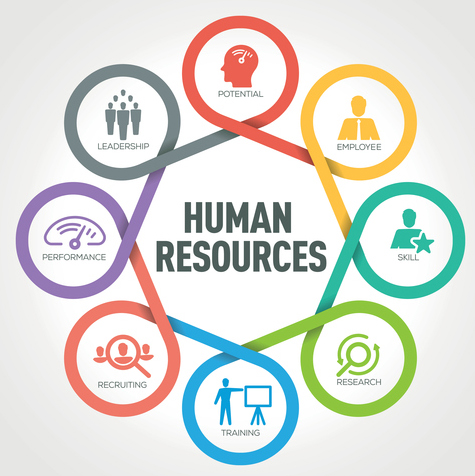

# <center>Human Resources and Candidate Search</center>
## <center>Web scrapping and candidates ranking</center>

**<p style="text-align:right">Made by Ihor Markevych</p>**

In [1]:
from requests import get
from warnings import warn
import json
import re
import csv
import pandas as pd
import numpy as np
import os
from PIL import Image

In [2]:
from fuzzywuzzy import fuzz
import nltk
# from nltk.corpus import wordnet 
nltk.download('wordnet')

from nltk.stem import PorterStemmer 
   
stemmer = PorterStemmer() 

import spacy

import en_core_web_md
# python -m spacy download en_core_web_md (run in anaconda prompt)
nlp = en_core_web_md.load()

# from spacy.matcher import PhraseMatcher

C:\Users\Dergel\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dergel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


_splits `txt` string based on list of separators `seps`_

In [3]:
def split(txt, seps):
    default_sep = seps[0]

    # we skip seps[0] because that's the default separator
    for sep in seps[1:]:
        txt = txt.replace(sep, default_sep)
    return [i.strip() for i in txt.split(default_sep)]

| Variable                | Explanation  |
|-------------------------|---|
| `minCandidates`         | minimum quantity of candidates to be scrapped        |
| `minJobs`               | quantity of job posts to be retrieved                |
| `topCandidatesNumber`   | quantity of candidates to be invited to an interview |

In [4]:
minCandidates = 15
minJobs = 5
topCandidatesNumber = 5

## API reading of jobs from Google

Using API requests retrieve JSON of job posts on Google Careers.  
Using generators create a csv file with scrapped information.  
  
Information, that is scrapped:  
* Company Name
* Job Title
* Locations
* Education as pair of
    * degree
    * area
* Experience:
    * Pairs of
        * year
        * area
    * areas (without years specified)
* Summary
* Description
* Job Link

We extract information from JSON response and parse it with regex to extract degree and its area and different areas of experience and minimum required number of years for specific area. Results are saved as list of lists where first element in list of required experience years matches first list (that contains skills/techstack) from list of lists of areas.  
We create a csv with extracted jobs after.

In [5]:
# Inspired by https://towardsdatascience.com/scraping-the-top-5-tech-company-job-boards-957b5f65da80

pagesNumber = 2 # how many pages to scrap

def get_all_jobs(pages):
#     requests = 0
#     start_time = time()
#     total_runtime = datetime.now()
    for page in pages:
        response = get("https://careers.google.com/api/jobs/jobs-v1/search/?company=Google&company=YouTube&"
                       "employment_type=FULL_TIME&hl=en_US&jlo=en_US&location=California%2C%20USA&"
                       "location=Oregon%2C%20USA&location=Washington%2C%20USA&page={}&"
                       "q=&sort_by=relevance".format(page))

        # Monitor the frequency of requests
#         requests += 1

#         # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn("Request: {}; Status code: {}".format(requests, response.status_code))

#         # Set page requests. Break the loop if number of requests is greater than expected
#         if requests > 8:  #88
#             warn("Number of requests was greater than expected.")
#             break

        yield from get_job_infos(response)


def get_job_infos(response):
    google_jobs = json.loads(response.text)
    for website in google_jobs['jobs']:
        google_job_id = website['job_id']
        try:
            found_id = re.search('jobs/(\d+)', google_job_id).group(1)
        except AttributeError:
            found_id = None
        site = website["company_name"]
        title = website["job_title"]
        locations = website['locations']
        
        summary = website['summary']

        req = re.findall('<li>(.+?)</li>', summary.replace("\n", " "))
        expYears = []
        expAreas = []
        expAreas2 = []
        for line in req:
        #     experience with years specified
            exp = re.search('(\d+) years of( .+?)? experience(?: in)?(?: with)? (.+)', line)
            if exp is not None:
                expYears.append(exp.group(1))
                areas = split(exp.group(3), [', ', ', and', 'or ', '.'])
                if exp.group(2) is not None:
                    areas.append(exp.group(2))
                while("" in areas): 
                    areas.remove("") 
                expAreas.append(areas)
                continue

        #      degree
            degree = ''
            degreeArea = ''
            deg = re.search('(.+) degree(?: in )?(.*?)(?:[,.;]|(?: or ))', line)
            if deg is not None:
                degree = deg.group(1).split('/')
                degreeArea = deg.group(2)
                continue

        #     experience without years specified
            exp2 = re.search('(?i)(.*)experience (?:in )?(?:with )?(.+)', line)
            if exp2 is not None:
                areas = split(exp2.group(2), [',', 'and', 'such as', 'like', 'etc', '.', ';'])
                if exp2.group(1) is not None:
                    areas.append(exp2.group(1))
                while("" in areas): 
                    areas.remove("") 
                expAreas2.append(areas)
                continue
        
        job_link = "https://careers.google.com/jobs/results/" + found_id
        summary = summary.replace('<ul>', '').replace('<li>', '').replace('</ul>', '').replace('</li>', '')
        description = website['description'].replace('<p>', '').replace('</p>', '\n').replace('&#39;', '\'')
        
        yield site, title, locations, expYears, expAreas, degree, degreeArea, expAreas2, job_link, description, summary

def createJobsCSV():
    # Set the number of pages to scrape
    pages = [str(i) for i in range(1, pagesNumber)]

    # Writes to csv file
    with open('google_jobs.csv', "w", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Website", "Title", "Locations", 
                         "Experience Years", "Experience Areas", 
                         "Degree", "Degree Area", 
                         "Experience without years areas",
                         "Job URL", 'Description', 'Summary'])
        writer.writerows(get_all_jobs(pages))

In [6]:
createJobsCSV()

In [7]:
jobs = pd.read_csv('google_jobs.csv').head(minJobs)

In [8]:
jobs

,Website,Title,Locations,Experience Years,Experience Areas,Degree,Degree Area,Experience without years areas,Job URL,Description,Summary
0,Google,Software Engineer,"['San Francisco, CA, USA', 'Mountain View, CA,...",[],[],NaN,NaN,[['one or more general purpose programming lan...,https://careers.google.com/jobs/results/826522...,Google aspires to be an organization that refl...,"\nBS degree in Computer Science, similar techn..."
1,Google,"Senior HR Business Partner, Google Cloud","['Sunnyvale, CA, USA', 'Austin, TX, USA', 'Chi...",[],[],NaN,NaN,[['the following areas: organizational design'...,https://careers.google.com/jobs/results/936345...,People Operations strives to revolutionize hum...,\nBachelor's degree or equivalent practical ex...
2,Google,Operations Support Manager,"['Boulder, CO, USA', 'Mountain View, CA, USA']",['8'],[['at least 3 years of direct people managemen...,"[""Bachelor's""]",NaN,[],https://careers.google.com/jobs/results/112438...,gTech Users &amp; Products (gUP) builds innova...,\nBachelor's degree or equivalent practical ex...
3,Google,"Health Data Information Governance Lead, Googl...","['Palo Alto, CA, USA']",[],[],NaN,NaN,"[['global', 'European data protection laws', '...",https://careers.google.com/jobs/results/121922...,At Google we’re committed to improving the liv...,\nExperience with global and European data pro...
4,Google,"Head of Strategy and Operations, Growth and Op...","['Mountain View, CA, USA']",['10'],"[['Marketing', 'Strategy and Operation']]","[""Bachelor's""]",NaN,[],https://careers.google.com/jobs/results/102864...,Whether you're on a consumer product (like Gma...,\nBachelor's degree or equivalent practical ex...


## Web scrapping of Livecareer for candidates

In [9]:
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options 
from selenium.webdriver.common.keys import Keys

_clean skills from unneeded symbols_  
In this implementation we ignore "minimum years" requirement for skills for sake of simplicity.

In [10]:
def cleanSkills(job, stem=True):
    skills = [x for x in job[['Experience Areas', 'Degree Area', 'Experience without years areas']]]
    skills = [x for x in skills if str(x) != 'nan' and x != '[]']
    skills = [split(x, ['[', ']', '/', '\'', ','] ) for x in skills][0]
    skills = [x for x in skills if x != '']
    if stem:
        skills = [stemmer.stem(x) for x in skills]
    return skills

Initialize Selenium Webdriver.  
**Should be acompanied by file `./chromedriver.exe`**, which can be found [here](https://chromedriver.chromium.org/).

In [11]:
webdriver = "./chromedriver.exe"
chrome_options = Options()  
chrome_options.add_argument("--headless")
driver = Chrome(webdriver, options=chrome_options)

In [12]:
try:
    os.mkdir('./resumes')
except:
    ;

Scrap resumes from LiveCareer one by one with Selenium. Rank candidates by matching resume text and extracted skills. Save resumes as screenshots and total rank, also with rank for each skill.  
For ranking `FuzzyWuzzy` library was used together with `token_set_ratio` ratio ([explanation of differences between different token ratios](https://www.datacamp.com/community/tutorials/fuzzy-string-python)).

In [13]:
ranks = []
# resumeTexts = []
page = 0
rankSkillCandidate = []

i = 0
while len(ranks) < minCandidates:
    url = "https://www.livecareer.com/resume-search/search?jt=software%20development&pg="
    page += 1
    driver.get(url + str(page))
    items = driver.find_elements_by_class_name("resume-description") # list of elements that leads to resumes

    for resume in items:
        
#         scroll to resume
        driver.execute_script("arguments[0].scrollIntoView();", resume)
        resume.click() # go to resume page

        handles = driver.window_handles
        driver.switch_to.window(handles[len(handles) - 1]) # switch to tab with resume
        resume = driver.find_element_by_id('divResumeHTML')

        bodyText = resume.text # extract text
        
        # take a screenshot of page and cut it to contain only resume
        driver.set_window_size(resume.size["width"] + 500, resume.size["height"] + 1000) 
        location = resume.location
        size = resume.size
        driver.save_screenshot("temp.png")
        x = location['x']
        y = location['y']
        width = location['x'] + size['width']
        height = location['y'] + size['height']
        im = Image.open('temp.png')
        im = im.crop((int(x), int(y), int(width), int(height)))
        im.save('./resumes/' + str(i) + 'resume.png')
        os.remove('temp.png')
        i += 1
        
#         resumeTexts.append(bodyText)
        processedText = nlp(stemmer.stem(bodyText.lower().replace('\n', ' ')))
        
        ranksForJob = []
        rankSkillsJob = []
        
#         create a 3D array for skills ranks:
        for index, job in jobs.iterrows():
            skills = cleanSkills(job)

            rankSkills = []
            
            for skill in skills:
                rankSkills.append(fuzz.token_set_ratio(skill, processedText)) # array of rank[skill]
#             https://www.datacamp.com/community/tutorials/fuzzy-string-python
            ranksForJob.append(sum(rankSkills) // len(rankSkills)) # total ranks
            rankSkillsJob.append(rankSkills) # array of rank[job][skill] 

        ranks.append(ranksForJob) # total ranks
        rankSkillCandidate.append(rankSkillsJob) # array of rank[candidate][job][skill]
    
        driver.switch_to.window(driver.window_handles[0]) # go back to first tab with list of resumes
         
driver.quit()

ranksDF = pd.DataFrame(ranks, columns = jobs['Title']).T

Variable `rankSkillCandidate` has next dimentions: \[candidate\]\[job\]\[skill\] and contains rank for each candidate for each job for each skill.

# Ranking

In [14]:
from fpdf import FPDF
import unicodedata

Next function is needed for writing into pdf, it normalizes encoding and cleanes text.

In [15]:
def unicode_normalize(s):
    return str(unicodedata.normalize('NFKD', s)
               .encode('ascii', 'ignore')
               .decode()).replace('\\n', '\n').replace('"\'', '"').replace('\\\'', '\'' ).replace('<br>', '\n')

Create folder for pdf reports.

In [16]:
try:
    os.mkdir('./reports')
except:
    ;

Create a pdf reports for each job, which will include job information and candidate information (total rank, matched skills with rank, resume).

In [17]:
for job in range(minJobs):
    pdf = FPDF()
    pdf.add_page()
    
    # job info
    pdf.set_font("Arial", size=20)
    pdf.cell(200, 10, txt=ranksDF.iloc[job].name, ln=1, align="C") # job name
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 10, txt=jobs.iloc[job].loc['Job URL'], ln=1, align="C") # job url
    pdf.link(1, 1, 200, 10, jobs.iloc[job].loc['Job URL'])
    pdf.set_font("Arial", size=12)
    
    locs = split(jobs.iloc[job].loc['Locations'], ['[', ']', '/', '\', \'', '\'']) 
    while("" in locs):
        locs.remove('')
    pdf.multi_cell(0, 5, txt='Locations:\n' + '\n'.join(locs), align="L") # job locations
    pdf.cell(200, 2, ln=1, align="C")
    
    pdf.multi_cell(0, 5, txt=unicode_normalize(jobs.iloc[job].loc['Description']), align="C") # job decription   
    pdf.multi_cell(0, 5, txt=unicode_normalize(jobs.iloc[job].loc['Summary']), align="C") # job summary

    
    topRatings = ranksDF.iloc[job].sort_values(ascending=False).head(topCandidatesNumber) # rank candidates
    topCandidates = topRatings.index.values
    
    i = 0
    for candidate in topCandidates:
        pdf.add_page()
        i += 1
        pdf.set_font("Arial", size=18)
        pdf.cell(200, 10, txt= str(i) + '. Candidate ID: ' + str(candidate), ln=1, align="C") #candidate ID
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt='Total rank: ' + str(topRatings[candidate]), ln=1, align="L") # candidate total rank
        
        # skill for job and candidate rank for each skill
        for x in zip(cleanSkills(jobs.iloc[job], stem=False), rankSkillCandidate[candidate][job]):
            pdf.cell(200, 5, txt=x[0] + ':\t\t\t\t\t' + str(x[1]), ln=1, align="R")
            
        pdf.image('./resumes/' + str(candidate) + 'resume.png', w=150) # candidate resume (screenshoted)
#         pdf.set_font("Arial", size=9)
#         pdf.write(5, txt=unicode_normalize(resumeTexts[candidate]))   # candidate resume (plain text) 
    pdf.output('./reports/' + ranksDF.iloc[job].name.replace('/',' ') + '.pdf')

Create folder for csv reports.

In [18]:
try:
    os.mkdir('./csvs')
except:
    ;

Write a csv for each job with top matched candidates and their ID, total rank and rank for each skill required.

In [19]:
for job in range(minJobs):
    
    topRatings = ranksDF.iloc[job].sort_values(ascending=False).head(topCandidatesNumber)
    topCandidates = topRatings.index.values
    
    with open('./csvs/ToInterview' 
              + ranksDF.iloc[job].name.replace('/',' ') 
              + '.csv', "w", newline='', encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(['Most fit candidates for ' + ranksDF.iloc[job].name])
            writer.writerow(['', '', 'Skills'])
            writer.writerow(["ID", 'Total rank'] + cleanSkills(jobs.iloc[job], stem=False))
            for candidate in topCandidates:
                writer.writerow([candidate, topRatings[candidate]] + rankSkillCandidate[candidate][job])

Delete folder with resumes.

In [20]:
import shutil
shutil.rmtree('./resumes')

Future improvements:
* Take "minimum years" requirement into account.
* Rank candidates not just by matching skill, but by level of experience with this skill.
* Add ranking by universities where candidate got degree(s) by matching with university rank in area